In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss_L1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss_L1(self, size_average=True):
        loss = torch.abs(self.hidden)
        if size_average:
            self._loss_L1 = loss.mean()
        else:
            self._loss_L1 = loss.sum()
        return self._loss_L1
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
models = {'64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss_L1 = model.loss_L1()
            loss = model.loss(output, data) + loss_L1
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._loss_L1))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
L1_lambda = lambda p: 'L1 loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + L1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    loss_L1 = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                loss_L1[k] += m.loss_L1(size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        loss_L1[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], loss_L1[k]))
    
    lines = '\n'.join([line(k, test_loss[k], loss_L1[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.985507
Train Epoch: 1 [12800/50000 (26%)]	Losses 64: 0.695946
Train Epoch: 1 [25600/50000 (51%)]	Losses 64: 0.393921
Train Epoch: 1 [38400/50000 (77%)]	Losses 64: 0.286481
Train Epoch: 1 [12512/50000 (100%)]	Losses 64: 0.252512
Test set:
64: loss: 0.2425	L1 loss: 0.0032

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.247552
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.214705
Train Epoch: 2 [25600/50000 (51%)]	Losses 64: 0.206659
Train Epoch: 2 [38400/50000 (77%)]	Losses 64: 0.184571
Train Epoch: 2 [12512/50000 (100%)]	Losses 64: 0.166767
Test set:
64: loss: 0.1670	L1 loss: 0.0025

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.174448
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.156546
Train Epoch: 3 [25600/50000 (51%)]	Losses 64: 0.151040
Train Epoch: 3 [38400/50000 (77%)]	Losses 64: 0.140053
Train Epoch: 3 [12512/50000 (100%)]	Losses 64: 0.133744
Test set:
64: loss: 0.1360	L1 loss: 0.0022

Train Epoch: 4 [0/50000 (0%)]	Losses 64: 0.139466
Train

Test set:
64: loss: 0.0317	L1 loss: 0.0008

Train Epoch: 27 [0/50000 (0%)]	Losses 64: 0.031495
Train Epoch: 27 [12800/50000 (26%)]	Losses 64: 0.034170
Train Epoch: 27 [25600/50000 (51%)]	Losses 64: 0.030130
Train Epoch: 27 [38400/50000 (77%)]	Losses 64: 0.029271
Train Epoch: 27 [12512/50000 (100%)]	Losses 64: 0.032281
Test set:
64: loss: 0.0309	L1 loss: 0.0008

Train Epoch: 28 [0/50000 (0%)]	Losses 64: 0.029060
Train Epoch: 28 [12800/50000 (26%)]	Losses 64: 0.026633
Train Epoch: 28 [25600/50000 (51%)]	Losses 64: 0.033252
Train Epoch: 28 [38400/50000 (77%)]	Losses 64: 0.030549
Train Epoch: 28 [12512/50000 (100%)]	Losses 64: 0.034976
Test set:
64: loss: 0.0309	L1 loss: 0.0008

Train Epoch: 29 [0/50000 (0%)]	Losses 64: 0.027913
Train Epoch: 29 [12800/50000 (26%)]	Losses 64: 0.029509
Train Epoch: 29 [25600/50000 (51%)]	Losses 64: 0.034086
Train Epoch: 29 [38400/50000 (77%)]	Losses 64: 0.027571
Train Epoch: 29 [12512/50000 (100%)]	Losses 64: 0.030739
Test set:
64: loss: 0.0303	L1 loss: 0.00

Train Epoch: 52 [38400/50000 (77%)]	Losses 64: 0.020416
Train Epoch: 52 [12512/50000 (100%)]	Losses 64: 0.023643
Test set:
64: loss: 0.0230	L1 loss: 0.0006

Train Epoch: 53 [0/50000 (0%)]	Losses 64: 0.022990
Train Epoch: 53 [12800/50000 (26%)]	Losses 64: 0.022486
Train Epoch: 53 [25600/50000 (51%)]	Losses 64: 0.026087
Train Epoch: 53 [38400/50000 (77%)]	Losses 64: 0.022288
Train Epoch: 53 [12512/50000 (100%)]	Losses 64: 0.019128
Test set:
64: loss: 0.0228	L1 loss: 0.0006

Train Epoch: 54 [0/50000 (0%)]	Losses 64: 0.023204
Train Epoch: 54 [12800/50000 (26%)]	Losses 64: 0.023830
Train Epoch: 54 [25600/50000 (51%)]	Losses 64: 0.019707
Train Epoch: 54 [38400/50000 (77%)]	Losses 64: 0.022098
Train Epoch: 54 [12512/50000 (100%)]	Losses 64: 0.021628
Test set:
64: loss: 0.0228	L1 loss: 0.0006

Train Epoch: 55 [0/50000 (0%)]	Losses 64: 0.024091
Train Epoch: 55 [12800/50000 (26%)]	Losses 64: 0.023798
Train Epoch: 55 [25600/50000 (51%)]	Losses 64: 0.022639
Train Epoch: 55 [38400/50000 (77%)]	Loss

Train Epoch: 78 [12800/50000 (26%)]	Losses 64: 0.023094
Train Epoch: 78 [25600/50000 (51%)]	Losses 64: 0.020025
Train Epoch: 78 [38400/50000 (77%)]	Losses 64: 0.019443
Train Epoch: 78 [12512/50000 (100%)]	Losses 64: 0.022470
Test set:
64: loss: 0.0210	L1 loss: 0.0005

Train Epoch: 79 [0/50000 (0%)]	Losses 64: 0.022636
Train Epoch: 79 [12800/50000 (26%)]	Losses 64: 0.022492
Train Epoch: 79 [25600/50000 (51%)]	Losses 64: 0.019555
Train Epoch: 79 [38400/50000 (77%)]	Losses 64: 0.019965
Train Epoch: 79 [12512/50000 (100%)]	Losses 64: 0.018150
Test set:
64: loss: 0.0208	L1 loss: 0.0005

Train Epoch: 80 [0/50000 (0%)]	Losses 64: 0.021106
Train Epoch: 80 [12800/50000 (26%)]	Losses 64: 0.019739
Train Epoch: 80 [25600/50000 (51%)]	Losses 64: 0.020147
Train Epoch: 80 [38400/50000 (77%)]	Losses 64: 0.020242
Train Epoch: 80 [12512/50000 (100%)]	Losses 64: 0.017308
Test set:
64: loss: 0.0210	L1 loss: 0.0005

Train Epoch: 81 [0/50000 (0%)]	Losses 64: 0.018999
Train Epoch: 81 [12800/50000 (26%)]	Loss

In [10]:
data, _ = next(iter(test_loader))
data = data.to(device)

output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.6).sum(1))
    encoded[torch.abs(encoded) < 0.6] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

eye_decoded = models['64'].decode(torch.eye(64).to(device))
eye_to_plot = ((eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

minus_eye_decoded = models['64'].decode(-1.0 * torch.eye(64).to(device))
minus_eye_to_plot = ((minus_eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()



tensor([ 1,  3,  0,  0,  0,  0,  0,  0,  1,  2,  0,  2,  0,  1,
         0,  1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  1,  1,  0,  0,  0,  0,  2,  0,  1,  1,  0,  2,  0,
         1,  0,  0,  0,  1,  0,  0,  0], device='cuda:6')


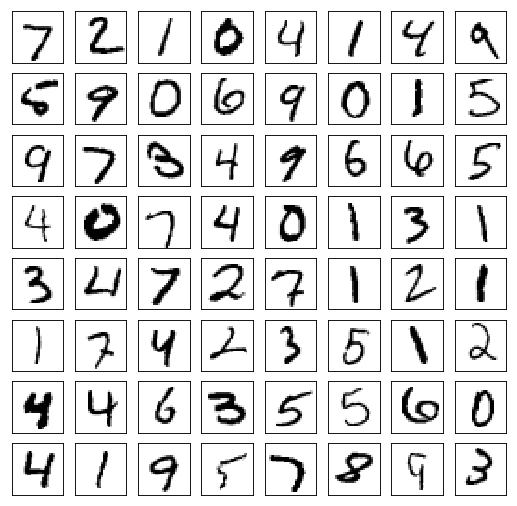

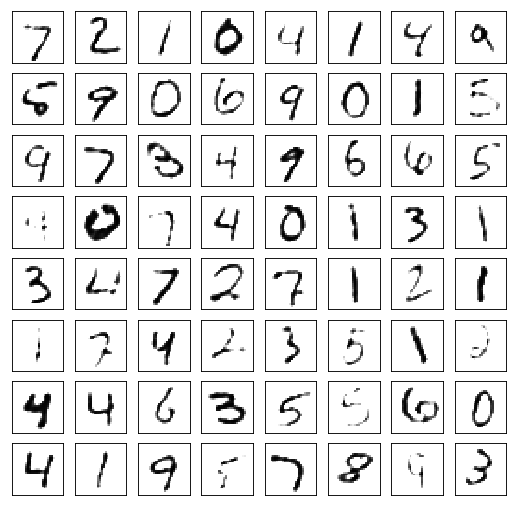

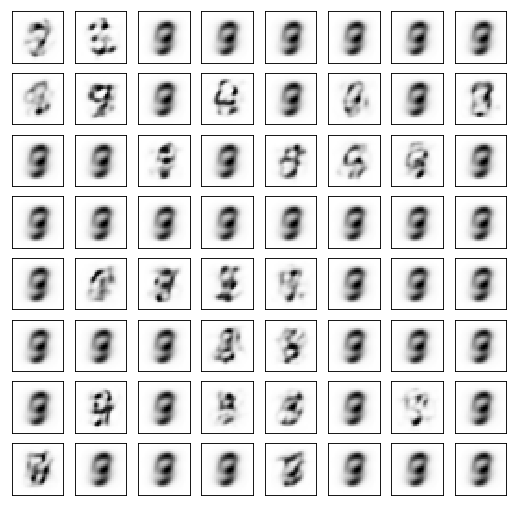

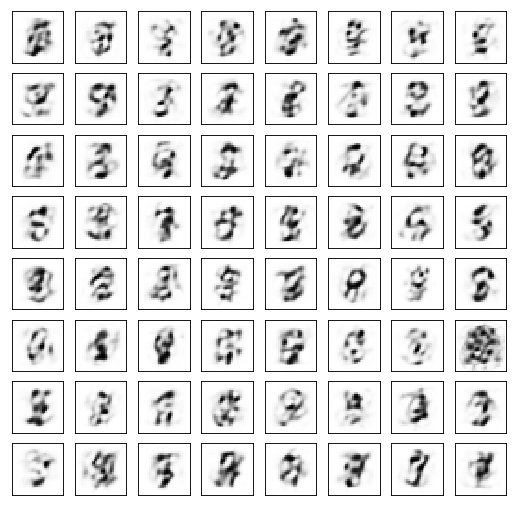

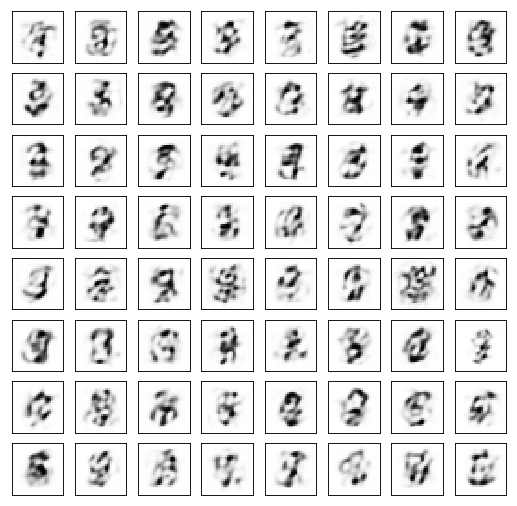

In [11]:
plot_mnist(data.data.cpu().numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(eye_to_plot, (8, 8))
plot_mnist(minus_eye_to_plot, (8, 8))

In [12]:
class EyeNet(nn.Module):
    def __init__(self, data):
        super().__init__()
        self.w = nn.Parameter(data)
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self):
        out = models['64'].E(self.w.view(-1, 28*28))
        return out

In [13]:
w, _ = next(iter(test_loader))
eye_model = EyeNet(w).to(device)
models['64'].eval()
eye_model.train()
for i in range(1, 100_001):
    eye_model.optim.zero_grad()
    out = eye_model()
    loss = F.mse_loss(out, torch.eye(64).to(device))
    loss.backward()
    eye_model.optim.step()
    if i % 1000 == 0:
        print(loss.item())

0.028057077899575233
0.009171632118523121
0.0025220667012035847
0.0007249704212881625
0.00027626199880614877
0.00013220870459917933
7.079979695845395e-05
4.027433169540018e-05
2.378394128754735e-05
1.4427559108298738e-05
8.952949428930879e-06
5.68201721762307e-06
3.696146222864627e-06
2.4729040433157934e-06
1.7079320286939037e-06
1.2211985449539497e-06
9.051616416400066e-07
6.950882607270614e-07
5.517258614418097e-07
4.5108043877917225e-07
3.783396778089809e-07
3.242422508265008e-07
2.829069956078456e-07
2.5053049057532917e-07
2.2460065451923583e-07
2.034239088288814e-07
1.858304017332557e-07
1.7099607418913365e-07
1.5832617350497458e-07
1.473842416999105e-07
1.3784156749352405e-07
1.2944809668624657e-07
1.2200874266454775e-07
1.1537110822246177e-07
1.0941343475678877e-07
1.0403539363323944e-07
9.915795828874252e-08
9.471384032622154e-08
9.064864769925407e-08
8.691558406326294e-08
8.347568325461907e-08
8.029650899743501e-08
7.734956142257943e-08
7.460970152806112e-08
7.205605356830347e

In [14]:
target_img = eye_model.w.detach()

In [15]:
eye = models['64'].E(target_img.view(-1,28*28))
print(eye.sum().item())
eye

63.91926574707031


tensor([[ 0.9987, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.9988,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.9988,  ..., -0.0000,  0.0000, -0.0000],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.9987, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.9987,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.9987]], device='cuda:6')

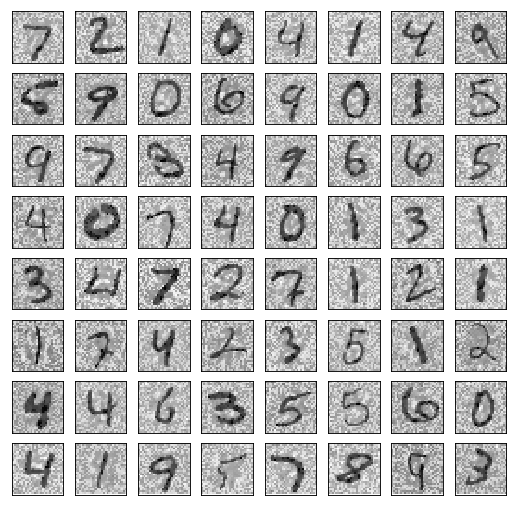

In [16]:
plot_mnist(target_img, (8,8))